/home_nfs/mimounis/iopa/IOanalytics/jobmodel/jobmodel


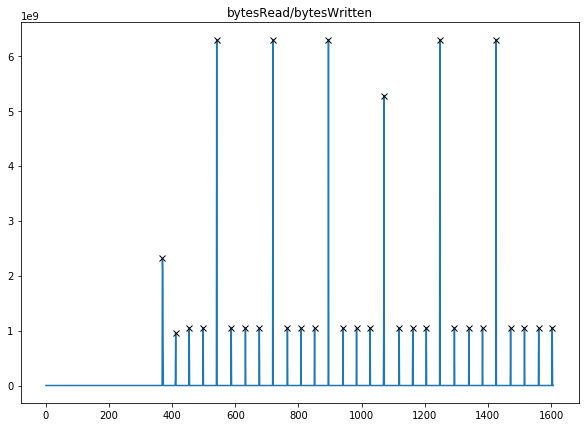

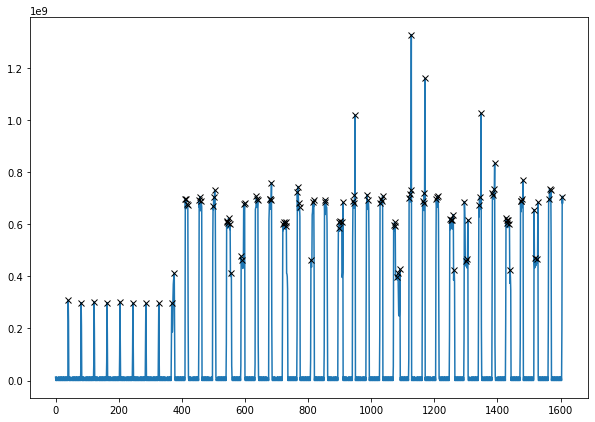

In [2]:
import numpy as np
from scipy import signal
import pickle
import sympy
import matplotlib.pyplot as plt
import os
print(os.getcwd())
with open('job_data.pkl', 'rb') as fp:
    data = pickle.load(fp)
jobids = list(data.keys())
j = 12
R = data[jobids[j]]['bytesRead']
W = data[jobids[j]]['bytesWritten']

plt.rcParams["figure.figsize"] = (10,7)
rpeaks, _ = signal.find_peaks(R, 32e6)
wpeaks, _ = signal.find_peaks(W, 32e6)
plt.plot(R)
plt.plot(rpeaks, R[rpeaks], 'xk')
plt.title('bytesRead/bytesWritten')
plt.show()
plt.plot(W)
plt.plot(wpeaks, W[wpeaks], 'xk')
plt.show()

#### Trying package from : https://github.com/ruipgil/changepy


In [3]:
# https://nikkimarinsek.com/blog/kleinberg-burst-detection-algorithm
# https://github.com/nmarinsek/burst_detection/blob/master/burst_detection_validation.ipynb

import burst_detection as bd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#r = pd.Series(W[0:600])
#d = pd.Series(np.ones(shape=r.shape)*np.max(r))
#timepoints = 1000
#signal = pd.Series(W) #total events
#d = pd.Series(np.ones(shape=signal.shape)*np.max(signal))   #target events
#print(signal.shape)

def burst_detect(W):
    signal = pd.Series(W) 
    d= np.ones(shape=signal.shape)*np.max(signal)
    n = len(signal)
    [q, _, _, p] = bd.burst_detection(signal, d, len(signal), 1.5, 2, smooth_win=0)
    bursts = bd.enumerate_bursts(q, 's='+str(1.5)+', g='+str(1.0))
    bursts = bd.burst_weights(bursts, signal, d, p)
    bursts.sort_index(inplace=True)
    return bursts

signal = W[250:450]
bursts = burst_detect(signal)
plt.rcParams["figure.figsize"] = (10,5)
print(bursts)
x = bursts['begin']-1
y = bursts['end']+1
plt.plot(signal, 'o-')
plt.plot(x, signal[x], '>g')
plt.plot(y, signal[y], '<r')

plt.grid(True)
plt.show()



/home_nfs/mimounis/iopa/IOanalytics/jobmodel/jobmodel/burst_detection.py:29: RuntimeWarning: invalid value encountered in double_scalars


ValueError: setting an array element with a sequence.

#### From change points to sequence decomposition



In [ ]:
bursts = burst_detect(signal)
plt.rcParams["figure.figsize"] = (10,5)
x = bursts['begin']-1
y = bursts['end']+1
#ti = [0, 20, 40, 60] # 4 events
#wi = [30e3, 30e3, 200e3, 100e3]
ts = 5
ti = list(x)
dti = list(y-x)
wi = [ts*np.trapz(signal[t[0]:t[1]]) for t in zip(x,y) ]
bi = [d[0]/(dti[0])/ts  for d in zip(wi, dti)]
print(f'ti={ti}')
print(f'bi={bi}')
print(f'wi={wi}')


#### Reconstruction with model and comparing


In [ ]:
from scipy import integrate
ts = 5 # sampling interval in seconds
ti=[39, 79-2, 120-2]
bi=[142512128.0, 147624618.6666667, 151294634.6666667]
wi=[2137681920.0, 2214369280.0, 2269419520.0]
def rect(x):
    return np.where(abs(x)<0.5, 1, 0)

def job_duration(ti, wi, bi, ts):
    lag =  ts*np.diff(np.insert(np.array([ti]), 0, 0))
    return np.sum((np.array(wi)/np.array(bi)) + lag)

def ts_job(ti, wi, bi, ts, expand=None):
    if expand is None:
        expand = job_duration(ti, wi, bi, ts)
        print(f'duration = {expand}s')
    t = np.linspace(0, expand, 3000)
    w = np.zeros(shape=t.shape)
    lag = 0
    tau = 0
    for i in range(len(ti)):
        tau = wi[i]/bi[i]
        w += bi[i]*rect((t-ti[i]*ts-lag-tau/2)/tau)
        lag = tau
    return t, w

def ts_plot(t, w, label=None):
    plt.rcParams["figure.figsize"] = (12,5)
    plt.rcParams['figure.facecolor'] = 'gray'
    plt.plot(t, w, lw=2, label=label)
    plt.plot(t[0], w[0], '>g')
    plt.plot(t[-1], w[-1], 'or')
    plt.grid(True)
    

job1 = (ti, wi, bi) # on BB
t, w = ts_job(ti, wi, bi, ts) 
ts_plot(t/ts, w*1.7)
plt.plot(signal)
plt.grid(True)
plt.show()
print(f'total volume = {np.trapz(signal)}')
print(f'total volume = {np.trapz(w, x=t)}')

